In [98]:
import h5py
import numpy as np
import cupy as cp
import pandas as pd
from cupyx.scipy.ndimage import convolve, laplace
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pygments.lexers import ml
from xarray import zeros_like

from generate_psf import fit_gaussian, weighted_linear_fit
import os
import glob
import skimage
import scipy
from skimage.filters.rank import threshold
from tqdm.auto import tqdm
import cv2
from lfm.util import create_projection_image
import json


In [80]:
pn_rec = r"Y:/hpc/r/lfm2025/recordings"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'psf.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250425_1537_PSF_LB_redFB_1-10000_2d_without_coverslip_4
20250425_1457_PSF_LB_redFB_1-10000_2d_without_coverslip_x100_1
20250425_1415_PSF_LB_redFB_1-10000_2d_without_coverslip_y100_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3
20250425_1242_PSF_LB_redFB_1-10000_2d_without_coverslip_2
20250425_1217_PSF_LB_redFB_1-10000_2d_without_coverslip_1
20250425_1138_PSF_LB_background
20250412_1700_LB_redFB_1-10000_3d_with coverslip_1
20250412_1656_LB_redFB_1-5000_3d_with coverslip_2
20250412_1654_LB_redFB_1-5000_3d_with coverslip_1
20250412_1651_LB_redFB_1-1000_3d_with coverslip_2
20250412_1649_LB_redFB_1-1000_3d_with coverslip_1
20250412_1604_PSF_LB_redFB_1-5000_withcoverslip_1
20250412_1539_PSF_LB_redFB_1-1000_withcoverslip_2
20250412_1513_PSF_LB_redFB_1-1000_withcoverslip_1


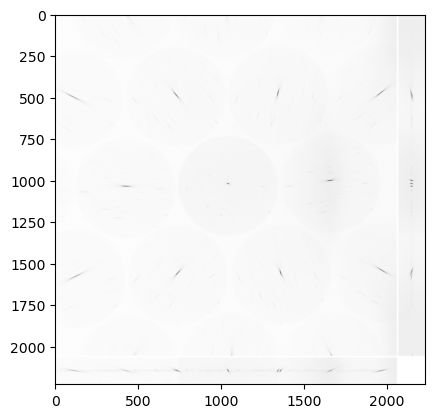

In [81]:
dataset_name = "20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3"
fn = os.path.join(pn_rec, dataset_name, 'psf.h5')
with h5py.File(fn, 'r') as f:
    psf = np.array(f['psf'])
plt.imshow(create_projection_image(psf,np.max,pad=10), cmap= "binary")
psf_orig = psf



detecting circles
computing circle peaks


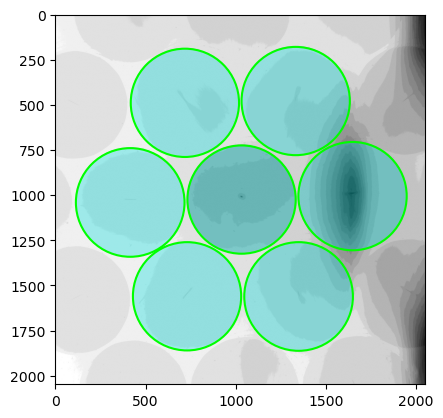

In [71]:
# detect the subimages
'''
 parameters to change:
 hough_radii -> which radii are used to fit circles

'''
lenses = 7 # number of full lenses visible in the psf


meanip = psf.mean(axis=0)
edges = skimage.feature.canny(meanip,sigma=2.0, low_threshold=0.55, high_threshold=0.8)
hough_radii = np.arange(260,310)
print("detecting circles")
hough_res = skimage.transform.hough_circle(edges,hough_radii)
print("computing circle peaks")
_ , cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res,
                                                         hough_radii,
                                                         total_num_peaks=lenses,
                                                         min_xdistance=200,
                                                         min_ydistance=200)
fig, ax = plt.subplots(ncols=1, nrows=1,)
color = meanip.max()+20
ml_masks = []
for center_y, center_x, radius in zip(cy, cx, radii):
    mask = np.zeros_like(meanip)
    mask[skimage.draw.disk((center_y, center_x), radius, shape=mask.shape)] = 1
    circle = Circle((center_x, center_y), radius, edgecolor='lime', facecolor='none',  linewidth=1.5)
    ml_masks.append(mask.astype(bool))
    ax.add_patch(circle)
ax.imshow(meanip.astype(np.uint8), cmap= "binary")
circle_mask = np.zeros_like(meanip).astype(bool)
for i, mask in enumerate(ml_masks):
    ax.imshow(np.ma.masked_where(~mask, mask), cmap='cool', alpha=0.3)
    circle_mask = circle_mask | mask
plt.show()

(1683, 1832)
(1683, 1832)
(1683, 1832)
(1683, 1832)
(1683, 1832)
(1683, 1832)
(1683, 1832)


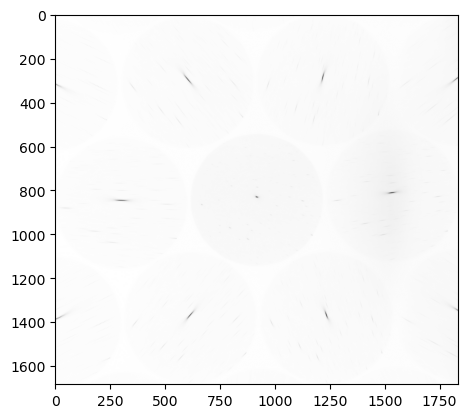

In [82]:
ys, xs = np.where(circle_mask)
y_min, y_max = ys.min(), ys.max()
x_min, x_max = xs.min(), xs.max()
crop = (y_min,y_max+1,x_min,x_max+1)
# This will give you the cropped mask:
cropped = circle_mask[crop[0]:crop[1], crop[2]:crop[3]]
psf = psf_orig[:,crop[0]:crop[1], crop[2]:crop[3]]
for i in range(len(ml_masks)):
    ml_masks[i] = ml_masks[i][crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(psf.max(axis=0),cmap= "binary")

In [83]:
#find plane with best focus
scores = []
for z in tqdm(range(psf.shape[0])):
    slice = cp.asarray(psf[z,:,:])
    scores.append(cp.var(laplace(slice)).get())
z_focus = np.argmax(scores)

  0%|          | 0/160 [00:00<?, ?it/s]

C:\Users\jlab\AppData\Local\Temp\ipykernel_25044\1482477804.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


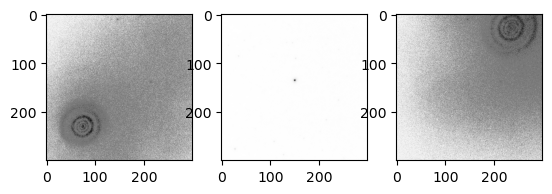

In [91]:
lens = 3
pad = 150 #how far from the center of the lens to plot
z_pad = 40# how many frames out of focus to plot, and where to stop fitting the function

fig, ax = plt.subplots(ncols=3, nrows=1,)

max_y,max_x = np.unravel_index(np.argmax(psf[z_focus-z_pad,:,:]*ml_masks[lens], axis=None),psf[0,:,:].shape)
im = psf[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min]
# im[:max_x,:max_y] = im.min()
ax[0].imshow(psf[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap= "binary")

ax[1].imshow(psf[z_focus,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap= "binary")
ax[2].imshow(psf[z_focus+z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap= "binary")
fig.show()

In [ ]:
for lens in tqdm(range(lens)):


In [94]:
values_dict = {}
init_radius = 0.5
init_search_radius = 5
init_search_r_range = 3
search_radius = 5
search_r_range = 3

for lens in tqdm(range(lenses)):
    values = pd.DataFrame(index=range(psf.shape[0]), columns= ["x","y","r",], data = None)


    z = z_focus
    slice = psf[z,:,:]*ml_masks[lens]
    y_max,x_max = np.unravel_index(np.argmax(psf[z_focus,:,:]*ml_masks[lens], axis=None),psf[0,:,:].shape)
    #feel free to add better peak detection for in focus bead
    x_focus,y_focus,r_focus, corr = fit_gaussian(slice, x=x_max, y=y_max, r=init_radius, search_radius=init_search_radius, search_r_range=init_search_r_range)
    x, y, r = x_focus, y_focus, r_focus
    values.loc[z,"x"]=x
    values.loc[z,"y"]=y
    values.loc[z,"r"]=r

    while z< psf.shape[0]-1:
        z += 1
        slice = psf[z,:,:]*ml_masks[lens]
        x,y,r,corr = fit_gaussian(slice, x, y, r, search_radius=search_radius, search_r_range=search_r_range)
        values.loc[z,"x"]=x
        values.loc[z,"y"]=y
        values.loc[z,"r"]=r

    z, x, y, r = z_focus, x_focus, y_focus, r_focus
    while z > 0:
        z -= 1

        slice = psf[z,:,:]*ml_masks[lens]
        x,y,r,corr = fit_gaussian(slice, x, y, r, search_radius=search_radius,search_r_range=search_r_range)
        values.loc[z,"x"]=x
        values.loc[z,"y"]=y
        values.loc[z,"r"]=r

    values_dict[lens]=values

  0%|          | 0/7 [00:00<?, ?it/s]

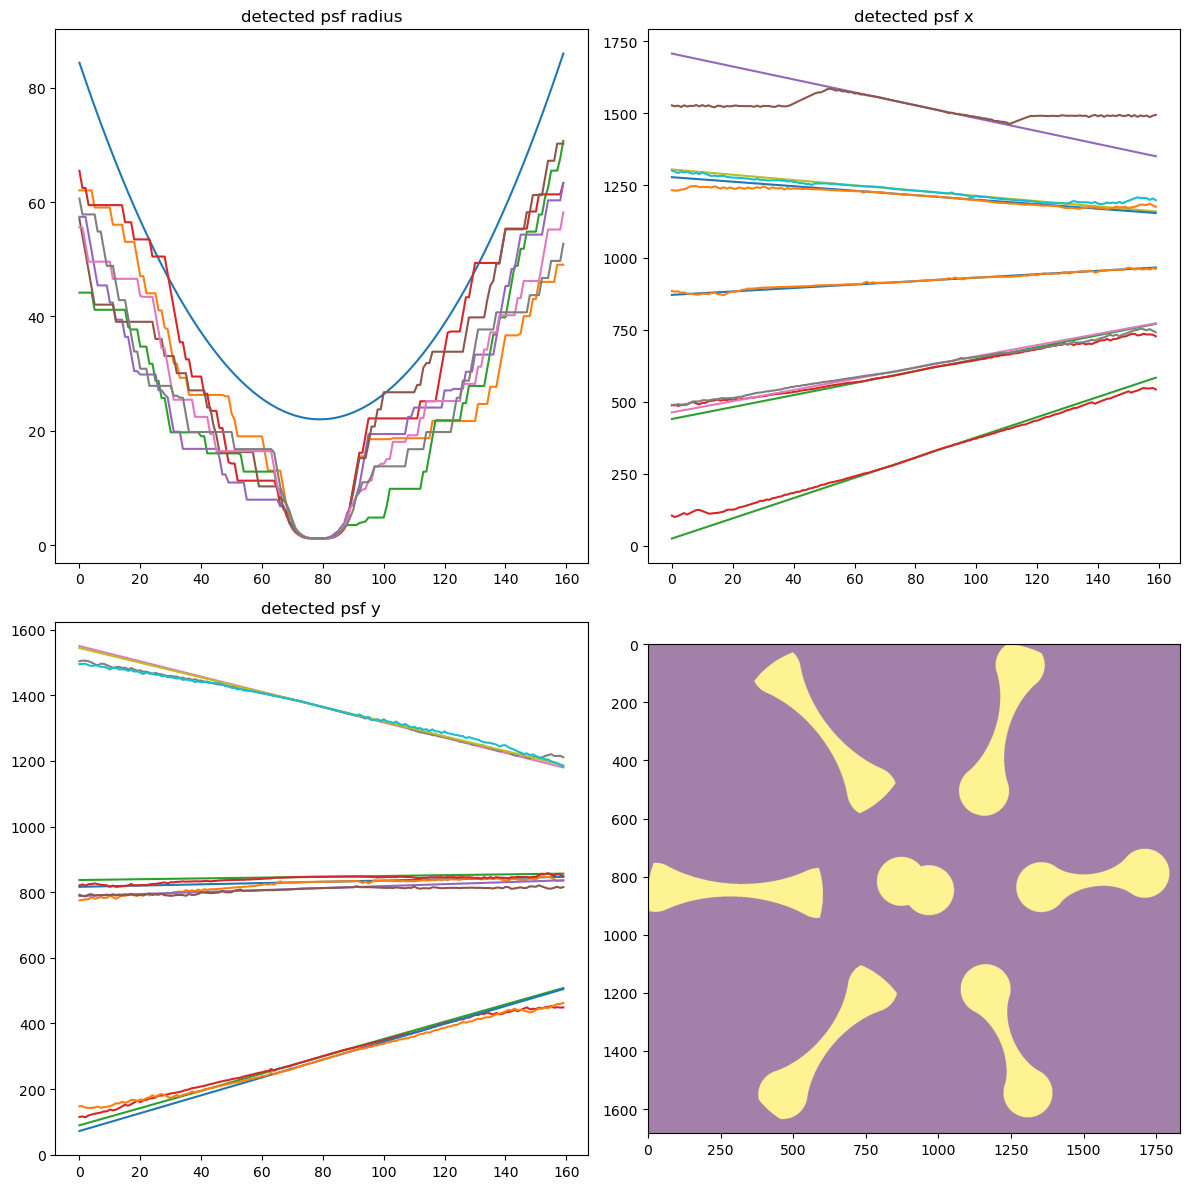

In [95]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
ax = axs.flatten()
#define filter radius
filter_radius = (1 / 100) * (np.arange(0, psf.shape[0]) - z_focus) ** 2 + 22
ax[0].plot(filter_radius)

mask = np.zeros_like(psf).astype(bool)

for lens in range(lenses):
    values = values_dict[lens]
    values["x_fit"] = weighted_linear_fit(values["x"], z=z_focus, weight_sigma=10)
    values["y_fit"] = weighted_linear_fit(values["y"], z=z_focus, weight_sigma=10)
    ax[0].plot(values["r"])
    ax[1].plot(values["x_fit"])
    ax[1].plot(values["x"])
    ax[2].plot(values["y_fit"])
    ax[2].plot(values["y"])

    temp_mask = np.zeros_like(psf).astype(bool)
    for z in range(psf.shape[0]):
        slice = temp_mask[z,:,:]
        center_x = values.loc[z,"x_fit"]
        center_y = values.loc[z,"y_fit"]
        radius = filter_radius[z]
        slice[skimage.draw.disk((center_y, center_x),radius , shape=psf.shape[1:])] = True
        temp_mask[z,:,:] = slice & ml_masks[lens]
    mask = mask | temp_mask

ax[0].set_title("detected psf radius") # should be somewhat parabolic, at least in center
ax[1].set_title("detected psf x") #should be linear
ax[2].set_title("detected psf y") #should be linear
ax[3].imshow(mask.max(axis=0), alpha=0.5)

fig.tight_layout()

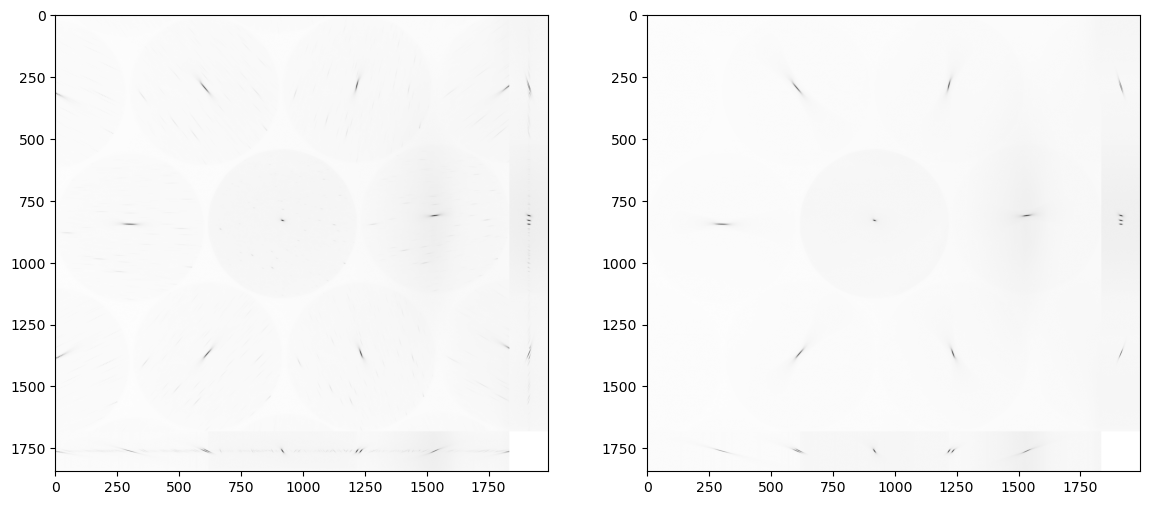

In [96]:
#filter
bg_mean = psf[np.r_[:10, -10:],:,:].mean(axis=0)
bg_std = psf[np.r_[:10, -10:],:,:].std(axis=0)
psf_filtered = np.random.normal(loc=bg_mean, scale=bg_std, size=psf.shape)
psf_filtered[mask] = psf[mask]

fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].imshow(create_projection_image(psf,np.max,pad=0), cmap='binary')
ax[1].imshow(create_projection_image(psf_filtered,np.max,pad=0), cmap='binary')

In [101]:
fn_new = fn[:-3]+"_filtered.h5"
bg_mean = psf[np.r_[:10, -10:],:,:].mean(axis=0)
with (h5py.File(fn_new, 'w') as f):
    f["psf"] = psf
    f["psf_clean"] = psf_filtered
    f["circle_mask"] = circle_mask
    f["bg"] = bg_mean
    f["crop"]=crop
    f["psf_mask"] = mask
    grp = f.create_group("filter_params")
    grp.attrs["lenses"] = lenses
    grp.attrs["search_radius"] = search_radius
    grp.attrs["search_r_range"] = search_r_range
    grp.attrs["init_radius"] = init_radius
    grp.attrs["init_search_radius"] = init_search_radius
    grp.attrs["init_search_r_range"] = init_search_r_range
# print("finished saving")

In [57]:
fn

'Y:/hpc/r/lfm2025/recordings\\20250425_1457_PSF_LB_redFB_1-10000_2d_without_coverslip_x100_1\\psf.h5'

In [425]:
savethis = dict(lenses=lenses,
                                    ml_masks=ml_masks,
                                    search_radius=search_radius,
                                    search_r_range=search_r_range,
                                    init_radius=init_radius,
                                    init_search_radius=init_search_radius,
                                    init_search_r_range=init_search_r_range,
                                    filter_radius=filter_radius,
                                    filter_masks=mask,
                                    )
for i in savethis:
    try:
        print(savethis[i].dtype)
    except:
        print(type(savethis[i]))

<class 'int'>
<class 'list'>
<class 'int'>
<class 'int'>
<class 'float'>
<class 'int'>
<class 'int'>
float64
bool


  0%|          | 0/160 [00:00<?, ?it/s]

TypeError: Image data of dtype complex128 cannot be converted to float

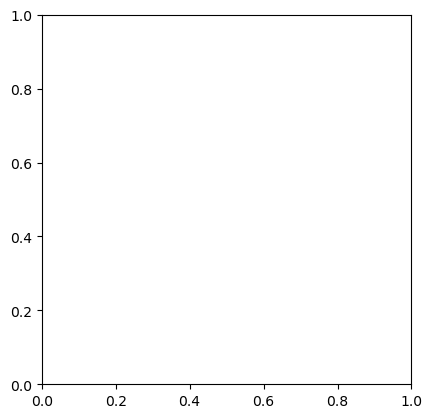

In [408]:
xy_pad = 201
otf = cp.zeros(shape=(psf.shape[0],psf.shape[1]+2*xy_pad,psf.shape[2]+2*xy_pad)).astype(np.complex128)

for z in tqdm(range(psf_filtered.shape[0])):
    slice = psf[z,:,:]
    otf[z,:,:] = cp.fft.fft2(cp.fft.ifftshift(cp.pad(slice, ((xy_pad,xy_pad), (xy_pad,xy_pad)), mode='constant', constant_values=0)))
plt.imshow(otf.max(axis=0), cmap="binary")


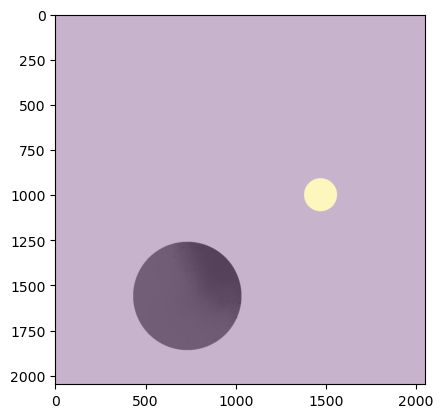

In [296]:
lens = 1
z = 150
slice = psf[z,:,:]*ml_masks[lens]
mask = np.zeros_like(slice_old).astype(bool)
mask[skimage.draw.disk((values_dict[lens].loc[z,"y_fit"], values_dict[lens].loc[z,"x_fit"]), filter_radius[z], shape=psf.shape[1:])] = True

plt.imshow(slice_old, cmap="binary")
plt.imshow(mask, alpha=0.3)
# plt.ylim(1500, 1750)
# plt.xlim(750, 1100)

In [298]:
psf.shape[1:]

(2048, 2048)

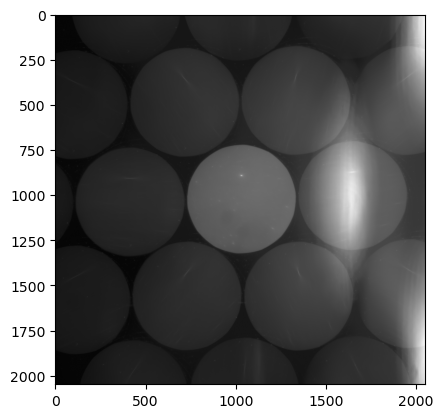

In [26]:
bg = psf[:10,:,:].mean(axis=0) + psf[-10:,:,:].mean(axis=0)
bg = psf.mean(axis=0)
plt.imshow(bg, cmap= "gray")

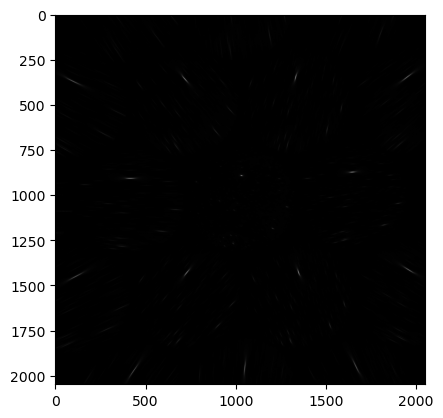

In [27]:
psf_bg = psf - bg
plt.imshow(psf_bg.max(axis=0), cmap='gray')

(array([8.23598600e+06, 5.33985670e+07, 5.98534191e+08, 1.08632920e+07,
        3.54170000e+04, 9.60900000e+03, 4.00300000e+03, 2.16100000e+03,
        1.39500000e+03, 9.12000000e+02, 5.80000000e+02, 4.11000000e+02,
        2.97000000e+02, 2.31000000e+02, 1.52000000e+02, 1.64000000e+02,
        1.22000000e+02, 1.14000000e+02, 8.70000000e+01, 5.80000000e+01,
        7.20000000e+01, 7.10000000e+01, 4.90000000e+01, 5.20000000e+01,
        3.90000000e+01, 4.60000000e+01, 4.00000000e+01, 3.20000000e+01,
        3.00000000e+01, 3.70000000e+01, 2.00000000e+01, 3.50000000e+01,
        1.70000000e+01, 2.20000000e+01, 2.20000000e+01, 2.90000000e+01,
        2.30000000e+01, 2.70000000e+01, 2.00000000e+01, 1.50000000e+01,
        1.60000000e+01, 1.50000000e+01, 1.20000000e+01, 1.30000000e+01,
        9.00000000e+00, 2.40000000e+01, 1.10000000e+01, 8.00000000e+00,
        3.40000000e+01, 5.10000000e+01]),
 array([-17.48  , -12.1326,  -6.7852,  -1.4378,   3.9096,   9.257 ,
         14.6044,  19.9518

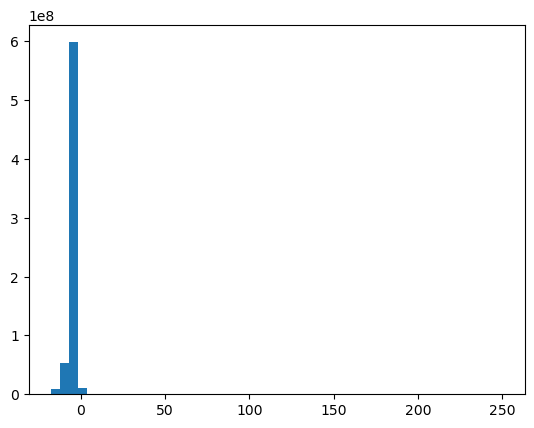

In [22]:
plt.hist(psf_bg.flatten(),bins = 50)

In [417]:
psf.max(axis=1).shape

(160, 2048)

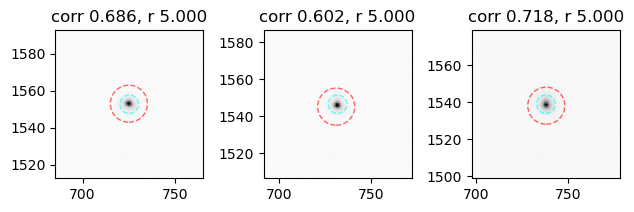

In [395]:
lens = 3
pad = 40 #how far from the center of the lens to plot
z_pad = 3# how many frames out of focus to plot, and where to stop fitting the function


fig,ax = plt.subplots(ncols=3,nrows=1,)
im = psf[z_focus-z_pad,:,:]*ml_masks[lens]
ax[0].imshow(im,cmap="binary")


y,x = np.unravel_index(im.argmax(),im.shape)
circle_init = Circle((x,y), 10, edgecolor='red', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='argmax (init)')

x_detect,y_detect,r_detect, corr = fit_gaussian(im, x=x, y=y, r=5, search_radius=5)
circle= Circle((x_detect,y_detect), r_detect, edgecolor='cyan', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='gaussian fit')

ax[0].add_patch(circle_init)
ax[0].add_patch(circle)
# ax[0].set_xlim(cx[lens]-pad, cx[lens]+pad)
# ax[0].set_ylim(cy[lens]-pad, cy[lens]+pad)
ax[0].set_xlim(x_detect-pad, x_detect+pad)
ax[0].set_ylim(y_detect-pad, y_detect+pad)
ax[0].set_title(f"corr {corr:.3f}, r {r_detect:.3f}")


im = psf[z_focus,:,:]*ml_masks[lens]
ax[1].imshow(im,cmap="binary")


y,x = np.unravel_index(im.argmax(),im.shape)
circle_init = Circle((x,y), 10, edgecolor='red', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='argmax (init)')

x_detect,y_detect,r_detect, corr = fit_gaussian(im, x=x, y=y, r=5, search_radius=5)
circle= Circle((x_detect,y_detect), r_detect, edgecolor='cyan', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='gaussian fit')

ax[1].add_patch(circle_init)
ax[1].add_patch(circle)
# ax[1].set_xlim(cx[lens]-pad, cx[lens]+pad)
# ax[1].set_ylim(cy[lens]-pad, cy[lens]+pad)
ax[1].set_xlim(x_detect-pad, x_detect+pad)
ax[1].set_ylim(y_detect-pad, y_detect+pad)
ax[1].set_title(f"corr {corr:.3f}, r {r_detect:.3f}")

im = psf[z_focus+z_pad,:,:]*ml_masks[lens]
ax[2].imshow(im,cmap="binary")


y,x = np.unravel_index(im.argmax(),im.shape)
circle_init = Circle((x,y), 10, edgecolor='red', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='argmax (init)')

x_detect,y_detect,r_detect, corr = fit_gaussian(im, x=x, y=y, r=5, search_radius=5)
circle= Circle((x_detect,y_detect), r_detect, edgecolor='cyan', facecolor='none',
                     linestyle='--', linewidth=1, alpha=0.6, label='gaussian fit')

ax[2].add_patch(circle_init)
ax[2].add_patch(circle)
# ax[2].set_xlim(cx[lens]-pad, cx[lens]+pad)
# ax[2].set_ylim(cy[lens]-pad, cy[lens]+pad)
ax[2].set_xlim(x_detect-pad, x_detect+pad)
ax[2].set_ylim(y_detect-pad, y_detect+pad)
ax[2].set_title(f"corr {corr:.3f}, r {r_detect:.3f}")
plt.tight_layout()

Outer Loop:   0%|          | 0/3 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/10 [00:00<?, ?it/s]

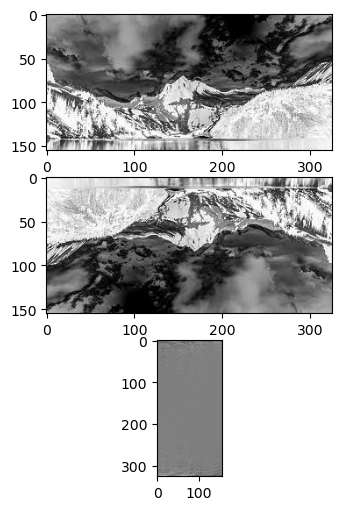

In [416]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# Load an image (grayscale for simplicity)
# Replace 'image_path' with the path of your image file
image_path = r"C:\Users\jlab\Repos\lfm\imaging\sampleimg.jpg"
original_image = io.imread(image_path)

# Convert to grayscale if the image is RGB
if original_image.ndim == 3:
    original_image = color.rgb2gray(original_image)

# Display the original image
fig, ax = plt.subplots(3,1,figsize=(12, 6))
ax[0].imshow(original_image,cmap = "binary")
ax[1].imshow(original_image[::-1,::-1],cmap = "binary")
fft_img = np.fft.fft2(original_image)
ht_img = fft_img.conj().T

ax[2].imshow(np.imag(np.fft.ifft(ht_img)),cmap = "binary")


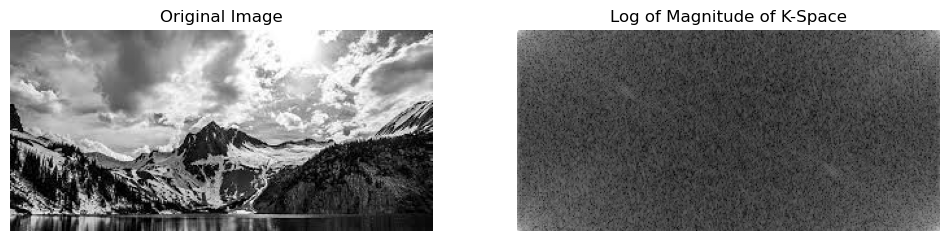

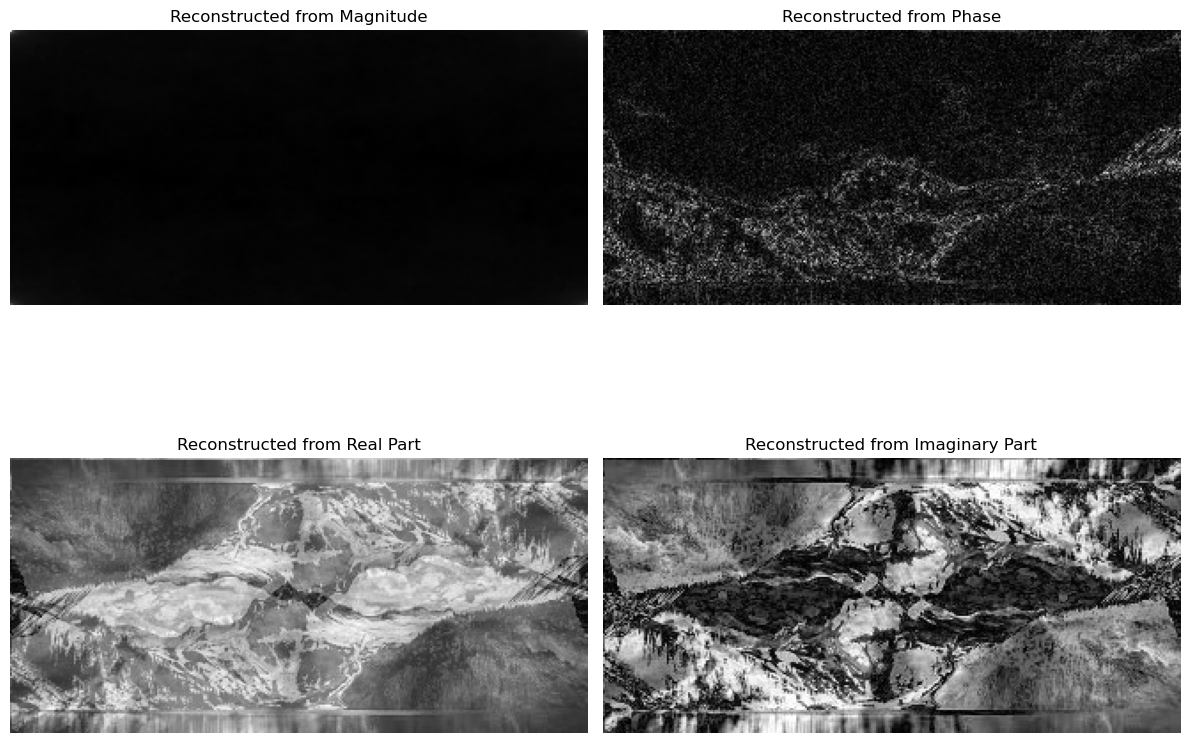

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# Load an image (grayscale for simplicity)
# Replace 'image_path' with the path of your image file
image_path = r"C:\Users\jlab\Repos\lfm\imaging\sampleimg.jpg"
original_image = io.imread(image_path)

# Convert to grayscale if the image is RGB
if original_image.ndim == 3:
    original_image = color.rgb2gray(original_image)

# Display the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Perform 2D Fourier Transform
FT_Image = np.fft.fft2(original_image)  # No fftshift here

# Extract k-space components
RealPart = np.real(FT_Image)
ImagPart = np.imag(FT_Image)
Magnitude = np.abs(FT_Image)
Phase = np.angle(FT_Image)

# Visualization of k-space components
plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + Magnitude), cmap='gray')
plt.title("Log of Magnitude of K-Space")
plt.axis('off')
plt.show()

# Reconstruction from Magnitude only
Magnitude_only = np.fft.ifft2(Magnitude)  # No ifftshift here
Reconstructed_Magnitude = np.abs(Magnitude_only)

# Reconstruction from the Phase only
Phase_only = np.exp(1j * Phase)  # Use unit magnitude with phase
Reconstructed_Phase = np.abs(np.fft.ifft2(Phase_only))

# Reconstruction from Real part only
Real_only = np.fft.ifft2(RealPart)
Reconstructed_Real = np.abs(Real_only)

# Reconstruction from Imaginary part only
Imag_only = np.fft.ifft2(1j * ImagPart)
Reconstructed_Imag = np.abs(Imag_only)

# Plotting the reconstruction results
plt.figure(figsize=(12, 10))

# Reconstructed from magnitude
plt.subplot(2, 2, 1)
plt.imshow(Reconstructed_Magnitude, cmap='gray')
plt.title("Reconstructed from Magnitude")
plt.axis('off')

# Reconstructed from phase
plt.subplot(2, 2, 2)
plt.imshow(Reconstructed_Phase, cmap='gray')
plt.title("Reconstructed from Phase")
plt.axis('off')

# Reconstructed from real part
plt.subplot(2, 2, 3)
plt.imshow(Reconstructed_Real, cmap='gray')
plt.title("Reconstructed from Real Part")
plt.axis('off')

# Reconstructed from imaginary part
plt.subplot(2, 2, 4)
plt.imshow(Reconstructed_Imag, cmap='gray')
plt.title("Reconstructed from Imaginary Part")
plt.axis('off')

plt.tight_layout()
plt.show()


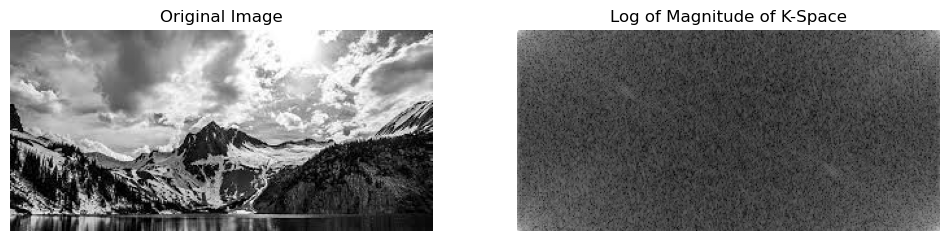

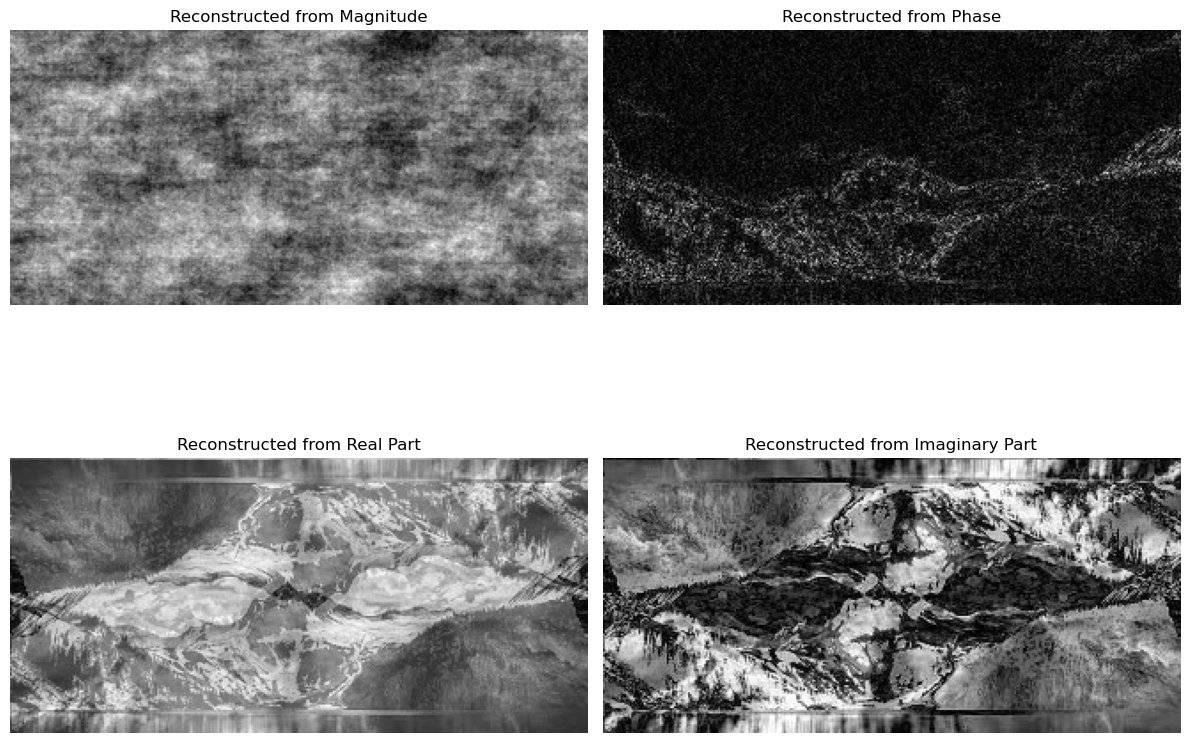

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# Load an image (grayscale for simplicity)
# Replace 'image_path' with the path of your image file
image_path = r"C:\Users\jlab\Repos\lfm\imaging\sampleimg.jpg"
original_image = io.imread(image_path)

# Convert to grayscale if the image is RGB
if original_image.ndim == 3:
    original_image = color.rgb2gray(original_image)

# Display the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Perform 2D Fourier Transform
FT_Image = np.fft.fft2(original_image)  # No fftshift here

# Extract k-space components
RealPart = np.real(FT_Image)
ImagPart = np.imag(FT_Image)
Magnitude = np.abs(FT_Image)
Phase = np.angle(FT_Image)

# Visualization of k-space components
plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + Magnitude), cmap='gray')
plt.title("Log of Magnitude of K-Space")
plt.axis('off')
plt.show()

# # Reconstruction from Magnitude only
# Magnitude_only = np.fft.ifft2(np.fft.ifftshift(Magnitude))
# Reconstructed_Magnitude = np.abs(Magnitude_only)

# Reconstruction from Magnitude only
random_phase = np.random.uniform(0, 2 * np.pi, Magnitude.shape)
Magnitude_with_random_phase = Magnitude * np.exp(1j * random_phase)  # Combine magnitude with random phase
Reconstructed_Magnitude = np.abs(np.fft.ifft2(Magnitude_with_random_phase))


# Reconstruction from the Phase only
Phase_only = np.exp(1j * Phase)  # Use unit magnitude with phase
Reconstructed_Phase = np.abs(np.fft.ifft2(Phase_only))

# Reconstruction from Real part only
Real_only = np.fft.ifft2(RealPart)
Reconstructed_Real = np.abs(Real_only)

# Reconstruction from Imaginary part only
Imag_only = np.fft.ifft2(1j * ImagPart)
Reconstructed_Imag = np.abs(Imag_only)

# Plotting the reconstruction results
plt.figure(figsize=(12, 10))

# Reconstructed from magnitude
plt.subplot(2, 2, 1)
plt.imshow(Reconstructed_Magnitude, cmap='gray')
plt.title("Reconstructed from Magnitude")
plt.axis('off')

# Reconstructed from phase
plt.subplot(2, 2, 2)
plt.imshow(Reconstructed_Phase, cmap='gray')
plt.title("Reconstructed from Phase")
plt.axis('off')

# Reconstructed from real part
plt.subplot(2, 2, 3)
plt.imshow(Reconstructed_Real, cmap='gray')
plt.title("Reconstructed from Real Part")
plt.axis('off')

# Reconstructed from imaginary part
plt.subplot(2, 2, 4)
plt.imshow(Reconstructed_Imag, cmap='gray')
plt.title("Reconstructed from Imaginary Part")
plt.axis('off')

plt.tight_layout()
plt.show()
